In [1]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

/Users/syuanbo/Documents/Project/SDGs/develop/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## UN Data preprocess

In [2]:
## SDGs Color Map
sdgs_color_code = {
    '0':'#000000',
    '1':'#E5243B',
    '2':'#DDA63A',
    '3':'#4C9F38',
    '4':'#C5192D',
    '5':'#FF3A21',
    '6':'#26BDE2',
    '7':'#FCC30B',
    '8':'#A21942',
    '9':'#FD6925',
    '10':'#DD1367',
    '11':'#FD9D24',
    '12':'#BF8B2E',
    '13':'#3F7E44',
    '14':'#0A97D9',
    '15':'#56C02B',
    '16':'#00689D',
    '17':'#19486A',
}

In [3]:
world_bank_custodian_indicators = [
    'Indicator1-1-1',
    'Indicator1-2-1',
    'Indicator1-4-2',
    'Indicator3-8-2',
    'Indicator5-1-1',
    'Indicator7-1-1',
    'Indicator8-10-2',
    'Indicator9-1-1',
    'Indicator9-3-2',
    'Indicator10-1-1',
    'Indicator10-2-1',
    'Indicator10-4-2',
    'Indicator10-7-1',
    'Indicator10-c-1',
    'Indicator15-a-1',
    'Indicator15-b-1',
    'Indicator16-5-2',
    'Indicator16-6-1',
    'Indicator17-3-2',
    'Indicator17-4-1',
    'Indicator17-13-1',
    'Indicator17-17-1',
]

world_bank_involved_indicators = [
    'Indicator1-2-2',
    'Indicator1-3-1',
    'Indicator2-3-2',
    'Indicator3-1-1',
    'Indicator3-2-1',
    'Indicator3-2-2',
    'Indicator4-2-1',
    'Indicator4-6-1',
    'Indicator5-5-1',
    'Indicator5-a-1',
    'Indicator5-a-2',
    'Indicator7-2-1',
    'Indicator7-3-1',
    'Indicator8-1-1',
    'Indicator8-2-1',
    'Indicator8-b-1',
    'Indicator9-2-1',
    'Indicator10-7-2',
    'Indicator16-10-2',
    'Indicator17-1-1',
    'Indicator17-18-3',
    'Indicator17-19-1',
]

In [7]:
# Read UN SDGs
un_sdgs = pd.read_csv(r'data/un_sdgs_indicators.csv')
un_sdgs['sentence'] = un_sdgs['indicator']+un_sdgs['description']
un_sentences = un_sdgs['sentence'].to_list()

pattern = r'Indicator(?P<Goal>\d+)-'
un_sdgs.insert(2, 'goal', un_sdgs['id'].str.extract(pattern))
un_sdgs.drop([un_sdgs.columns[0]],axis=1,inplace=True)

embeddings_un = model.encode(un_sentences, convert_to_tensor=True)

In [8]:
# Mapping colors for specific goals
un_sdgs['color'] = un_sdgs['goal'].map(sdgs_color_code)
print(un_sdgs.shape)
un_sdgs.head()

(248, 6)


,id,goal,indicator,description,sentence,color
0,Indicator1-1-1,1,Proportion of the population living below the ...,Definition:The indicator “proportion of the po...,Proportion of the population living below the ...,#E5243B
1,Indicator1-2-1,1,Proportion of population living below the nati...,Definition:The national poverty rate is the pe...,Proportion of population living below the nati...,#E5243B
2,Indicator1-2-2,1,"Proportion of men, women and children of all a...",Definition:The following five series are used ...,"Proportion of men, women and children of all a...",#E5243B
3,Indicator1-3-1,1,Proportion of population covered by social pro...,Definition:The indicator reflects the proporti...,Proportion of population covered by social pro...,#E5243B
4,Indicator1-4-1,1,Proportion of population living in households ...,Definition:The proportion of population living...,Proportion of population living in households ...,#E5243B


## TW Data Process

In [11]:
tw_sdgs = pd.read_csv(r'indicators_0424.csv')
tw_sdgs['sentence'] = tw_sdgs['指標 ']+": "+ tw_sdgs['定義'].fillna('')

# Filter New Taipei City
ntp_sdgs = tw_sdgs.loc[tw_sdgs['縣市']=='新北市', :]
ntp_sdgs = ntp_sdgs.astype('str')
ntp_sdgs['編號'] = ntp_sdgs['編號'].str.slice(stop=-2)
ntp_sdgs.head()
# ntp_sdgs.loc[:, '編號'] = ntp_sdgs.loc[:, '編號'].astype('int').astype('str')

,縣市,項目,指定Mapping,編號,指標,定義,相關敘述,sentence
0,新北市,1,Indicator1-1-1,14,低收入戶的人口比例,( 低收入戶人數 ÷ 新北市總人數）× 100%,nan,低收入戶的人口比例: ( 低收入戶人數 ÷ 新北市總人數）× 100%
1,新北市,10,Indicator10-1-1,13,戶數五等位所得差距倍數,第 5 分位組可支配所得 ÷ 第 1 分位組可支配所得,nan,戶數五等位所得差距倍數: 第 5 分位組可支配所得 ÷ 第 1 分位組可支配所得
2,新北市,11,Indicator11-1-1,16,居住扶助涵蓋率,( 租屋補貼及購屋補貼戶數 + 公益住宅提供戶數) ÷ 全市戶數,為減輕市民居住負擔，且考量多元族群、人口老化等問題，自 2019 年起以多元興辦模式推動社會...,居住扶助涵蓋率: ( 租屋補貼及購屋補貼戶數 + 公益住宅提供戶數) ÷ 全市戶數
3,新北市,10,Indicator11-2-1,19,復康巴士使用成長率,( 今年度使用復康巴士人數 ÷ 今年度市民總人口數）－（去年度使 用復康巴士人數 ÷ 去年度...,nan,復康巴士使用成長率: ( 今年度使用復康巴士人數 ÷ 今年度市民總人口數）－（去年度使 用復...
4,新北市,11,Indicator11-2-1,71,公共自行車使用人數,公共自行車租賃系統使用人次（不含河濱租賃系統）,nan,公共自行車使用人數: 公共自行車租賃系統使用人次（不含河濱租賃系統）


In [12]:
# Producing embedding
ntp_sentences = ntp_sdgs['sentence'].to_list()
embeddings_ntp = model.encode(ntp_sentences, convert_to_tensor=True)

In [13]:
not_mapping = {
    '縣市':'新北市',
    '項目':'0',
    '編號':'0',
    '指標 ':"Doesn't map any indicator"
}
ntp_sdgs = pd.concat([ntp_sdgs, pd.Series(not_mapping).to_frame().T],axis=0, ignore_index=True)

## Compute Semantic Similarity

In [15]:
from sentence_transformers import util
cosine_scores = util.cos_sim(embeddings_un, embeddings_ntp)

un_name = un_sdgs['id'].to_list()
ntp_name = ntp_sdgs['編號'].to_list()
ntp_name.remove('0')

df = pd.DataFrame(cosine_scores.cpu(), columns=ntp_name, index=un_name)

# melt table
df = df.reset_index()
df_melt = pd.melt(df, id_vars=['index'], value_name='SDGs')
df_melt['index'] = df_melt['index'].astype('str')
df_melt = df_melt.rename(columns={'index':'source', 'variable':'target', 'SDGs':'values'})
df_melt

,source,target,values
0,Indicator1-1-1,14,0.610190
1,Indicator1-2-1,14,0.610299
2,Indicator1-2-2,14,0.573944
3,Indicator1-3-1,14,0.586805
4,Indicator1-4-1,14,0.503294
...,...,...,...
20083,Indicator17-18-1,64,0.206389
20084,Indicator17-18-2,64,0.239131
20085,Indicator17-18-3,64,0.313443
20086,Indicator17-19-1,64,0.279235


In [16]:
## Draw Heatmap for cosine similarity
## Draw Heatmap for cosine similarity
df.index = df['index']
df_heatmap = df.drop(['index'], axis=1)
df_heatmap_sorted = df_heatmap.T.reindex([str(i) for i in list(range(1,82))]).T

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Heatmap(
    z= df_heatmap_sorted.T.values,
    x = df_heatmap_sorted.index,
    y = df_heatmap_sorted.columns,
))


fig.update_layout(
    width=800,
    height=500,
)

fig.show()


In [17]:
df.index = df['index']
df_heatmap = df.drop(['index'], axis=1)
df_heatmap_sorted = df_heatmap.T.reindex([str(i) for i in list(range(1,82))]).T

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Heatmap(
    z= np.where(df_heatmap_sorted.T.values>0.5, df_heatmap_sorted.T.values, 0),
    x = df_heatmap_sorted.index,
    y = df_heatmap_sorted.columns,
))


fig.update_layout(
    width=800,
    height=500,
)

fig.show()

## Compute Threshold (Using GPT to map indicators)

In [18]:
df_melt_mapping = df_melt.merge(un_sdgs[['id', 'sentence']], left_on='source', right_on='id', how='inner').drop(['id'], axis=1)
df_melt_mapping = df_melt_mapping.merge(ntp_sdgs[['編號', 'sentence']], left_on='target', right_on='編號', how='inner').drop(['編號'], axis=1)
df_melt_mapping = df_melt_mapping.sort_values(by='values', ascending=False)
df_melt_mapping = df_melt_mapping.rename(columns={'sentence_x':'sdg_sentence', 'sentence_y':'ntp_sentence'}).reset_index(drop=True)
df_melt_mapping.to_csv('mapping_result_values.csv')
df_melt_mapping

,source,target,values,sdg_sentence,ntp_sentence
0,Indicator3-4-2,34,0.809374,Suicide mortality rateDefinitions: The Suicid...,標準化自殺死亡率: 標準化自殺死亡率＝ [ Σ（年齡別自殺死亡率 × 標準年齡別人口 數）]...
1,Indicator12-5-1,10,0.784307,"National recycling rate, tons of material recy...",資源回收率: 資源回收量 ÷（垃圾量 + 資源回收量 + 廚餘量）
2,Indicator15-1-1,21,0.774649,Forest area as a proportion of total land area...,新北市森林覆蓋之土地面積比: (森林面積＋新北市地區造林面積 - 新北市地區森林災害) ÷\...
3,Indicator12-4-2,9,0.774174,(a) Hazardous waste generated per capita; and ...,有害事業廢棄物再利用率: 申報有害事業廢棄物再利用量 ÷ 申報有害事業廢棄物總產生量 × 100%
4,Indicator1-5-1,20,0.736317,"Number of deaths, missing persons and directly...",因天然災害導致人類傷亡人數: 每年因自然災害而死亡、失蹤和受傷之總人數
...,...,...,...,...,...
20083,Indicator12-2-1,40,-0.129031,"Material footprint, material footprint per cap...",兒童疾病的感染免疫措施: 完成接種疫苗兒童數 ÷ 應接種疫苗兒童數
20084,Indicator10-b-1,30,-0.138988,"Total resource flows for development, by recip...",18 歲以上男性嚼檳榔率: 依國健署「成人吸菸行為調查」及「健康危害因子監測調查」調查結果
20085,Indicator9-a-1,29,-0.139233,Total official international support (official...,18 歲以上吸菸率: 依據國健署「成人吸菸行為調查」調查結果
20086,Indicator16-4-1,24,-0.145134,Total value of inward and outward illicit fina...,社區志工防疫工作參與度: 每年度新北市各區公所動員社區志工協助病媒蚊孳生源清除或衛教 宣導活動場次


In [19]:
data = df_melt_mapping.iloc[:1000, 2]

fig = go.Figure(data=go.Scatter(x=data.index, y=data, mode='lines'))


# if threshold = 0.5
fig.add_hline(y=0.5, line_color='red')
fig.update_layout(
    title='Distribution of similarity between UN and New Taipei',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Value'),
    width=600,
    height=400
)

fig.show()

In [20]:
# df_melt_mapping.loc[:10, ['sdg_sentence', 'ntp_sentence']].values.tolist()
df_melt_mapping.loc[df_melt_mapping.shape[0]-10:, ['sdg_sentence', 'ntp_sentence']].values.tolist()

[['Debt service as a proportion of exports of goods and servicesDefinition:Debt service as proportion of exports of goods and services is the percentage of debt services (principle and interest payments) to the exports of goods and services. Debt services covered in this indicator refer only to public and publicly guaranteed debt.Concepts:Concepts of public and publicly guaranteed external debt data are in accordance with the sixth edition of the Balance of Payments and International Investment Position Manual (BPM6) methodology.“Exports of goods and services” data concepts are in accordance with the sixth edition of the Balance of Payments and International Investment Position Manual (BPM6).',
  '18 歲以上吸菸率: 依據國健署「成人吸菸行為調查」調查結果'],
 ['Annual growth rate of real GDP per employed personDefinition:\xa0The annual growth rate of real Gross Domestic Product (GDP) per employed person conveys the annual percentage change in real GDP per employed person.\xa0\xa0Concepts:\xa0GDP: It is the main m

In [21]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate
)
from langchain_community.callbacks import get_openai_callback
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(api_key=os.environ.get('API_KEY'), model='gpt-4-turbo', temperature=0)

un_indicators_ex1 = 'Suicide mortality rate,"Definitions:  The Suicide mortality rate as defined as the number of suicide deaths in a year, divided by the population, and multiplied by 100 000. Concepts:"'
ntp_indicators_ex1 = '標準化自殺死亡率,標準化自殺死亡率＝ [ Σ（年齡別自殺死亡率 × 標準年齡別人口 數）] ÷ 標準總人口數,'

un_indicators_ex2 = 'Total official international support (official development assistance plus other official flows) to infrastructure,"Definitions:Gross disbursements of total ODA and other official flows from all donors in support of infrastructure.Concepts:ODA: The DAC defines ODA as “those flows to countries and territories on the DAC List of ODA Recipients and to multilateral institutions which are provided by official agencies, including state and local governments, or by their executive agencies; and each transaction   is administered with the promotion of the economic development and welfare of developing countries as its main objective; andis concessional in character and conveys a grant element of at least 25 per cent (calculated at a rate of discount of 10 per cent). (See http://www.oecd.org/dac/stats/officialdevelopmentassistancedefinitionandcoverage.htm)Other official flows (OOF): Other official flows (excluding officially supported export credits) are defined as transactions by the official sector which do not meet the conditions for eligibility as ODA, either because they are not primarily aimed at development, or because they are not sufficiently concessional.(See http://www.oecd.org/dac/stats/documentupload/DCDDAC(2016)3FINAL.pdf,  Para 24).Support to infrastructure includes all CRS sector codes in the 200 series (see here: http://www.oecd.org/dac/stats/purposecodessectorclassification.htm)"'
ntp_indicators_ex2 = '18 歲以上男性嚼檳榔率,依國健署「成人吸菸行為調查」及「健康危害因子監測調查」調查結果,'

un_indicators_ex3 = 'Death rate due to road traffic injuriesDefinition:  Death rate due to road traffic injuries as defined as the number of road traffic fatal injury deaths per 100,000 population.  Concepts:  Numerator: Number of deaths due to road traffic crashes  Absolute figure indicating the number of people who die as a result of a road traffic crash.  Denominator: Population (number of people by country)'
ntp_indicators_ex3 = '每萬輛機動車輛死亡人數: 每年道路交通事故死亡人數）÷（每年年中機動車輛數） × 10,000'

un_indicators_ex4 = 'Number of people requiring interventions against neglected tropical diseasesDefinition:Number of people requiring treatment and care for any one of the neglected tropical diseases (NTDs) targeted by the WHO NTD Roadmap and World Health Assembly resolutions and reported to WHO.Concepts:Treatment and care is broadly defined to allow for preventive, curative, surgical or rehabilitative treatment and care. In particular, it includes both: 1) Average annual number of people requiring mass treatment known as preventive chemotherapy (PC) for at least one PC-NTD; and2) Number of new cases requiring individual treatment and care for other NTDs.Other key interventions against NTDs (e.g. vector management, veterinary public health, water, sanitation and hygiene) are to be addressed in the context of other targets and indicators, namely Universal Health Coverage (UHC) and universal access to water and sanitation.'
ntp_indicators_ex4 = '犯罪發生率: ( 犯罪發生件數 ÷ 每十萬人口）× 100%'

## Chat Model
examples = [
    {"input":f"{un_indicators_ex1} & {ntp_indicators_ex1}", "output":"Similar"},
    {"input":f"{un_indicators_ex2} & {ntp_indicators_ex2}", "output":"Different"},
    {"input":f"{un_indicators_ex3} & {ntp_indicators_ex3}", "output":"Similar"},
    {"input":f"{un_indicators_ex4} & {ntp_indicators_ex4}", "output":"Different"}
]

example_prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}"),
    ("ai", "{output}"),
])

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
# print(few_shot_prompt.format())

final_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", "You are the head of the Sustainable Development Goals(SDGs) project at the United Nations, \
        #  you will answer questions regarding the comparison of indicators between the UN and local Governments."),
        # ("system", "you will compare the SDGs indicators between United Nations and Local Governments"),
        ("system", "Only respond with 'Similar' or 'Different' when comparing indicators. If the indicators are relevant, return 'Similar'; otherwise, return 'Different'."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)
output_parser = StrOutputParser()
chain = final_prompt | llm | output_parser

test_example = """
"Growth rates of household expenditure or income per capita among the bottom 40 per cent of the population and the total populationDefinition:The growth rate in the welfare aggregate of bottom 40% is computed as the annualized average growth rate in per capita real consumption or income of the bottom 40% of the income distribution in a country from household surveys over a roughly 5-year period.The national average growth rate in the welfare aggregate is computed as the annualized average growth rate in per capita real consumption or income of the total population in a country from household surveys over a roughly 5-year period.Concepts:Promoting shared prosperity is defined as fostering income growth of the bottom 40 percent of the welfare distribution in every country and is measured by calculating the annualized growth of mean per capita real income or consumption of the bottom 40 percent. The choice of the bottom 40 percent as the target population is one of practical compromise. The bottom 40 percent differs across countries depending on the welfare distribution, and it can change over time within a country. Because boosting shared prosperity is a country-specific goal, there is no numerical target defined globally.",
失業率: 失業者 ÷ 勞動力 ×100%
"""

# chain.invoke(f"{test_example}")

test_example_1 = df_melt_mapping.loc[:499, ['sdg_sentence', 'ntp_sentence']].values.tolist()
# test_example_2 = df_melt_mapping.loc[500:999, ['sdg_sentence', 'ntp_sentence']].values.tolist()
# test_example_3 = df_melt_mapping.loc[1000:1499, ['sdg_sentence', 'ntp_sentence']].values.tolist()
# test_example_4 = df_melt_mapping.loc[1500:1999, ['sdg_sentence', 'ntp_sentence']].values.tolist()
# similar_test_example = df_melt_mapping.loc[:10, ['sdg_sentence', 'ntp_sentence']].values.tolist()
# different_test_example = df_melt_mapping.loc[df_melt_mapping.shape[0]-10:, ['sdg_sentence', 'ntp_sentence']].values.tolist()
with get_openai_callback() as cb:
    result_1 = await chain.abatch([
        *test_example_1,
        # *similar_test_example,
        # *different_test_example
    ])
    print(cb)

# with get_openai_callback() as cb:
#     result_2 = await chain.abatch([
#         *test_example_2, 
#     ])
#     print(cb)

# with get_openai_callback() as cb:
#     result_3 = await chain.abatch([
#         *test_example_3, 
#     ])
#     print(cb)

# with get_openai_callback() as cb:
#     result_4 = await chain.abatch([
#         *test_example_4, 
#     ])
#     print(cb)

# chain.invoke(test_example)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tokens Used: 825520
	Prompt Tokens: 825020
	Completion Tokens: 500
Successful Requests: 500
Total Cost (USD): $8.265200000000004


In [28]:
df_melt_mapping.loc[:499, 'gpt_answer'] = result_1
df_melt_mapping.loc[:499,:].to_csv(r'compare_gpt_similarity.csv')
# result_1

In [23]:
from collections import Counter
import plotly.graph_objects as go
import numpy as np

# result = result_1 + result_2 + result_3 + result_4
result = result_1
value_counts = Counter(result)
print(f"Similar和different在similarity top {len(result)} 中的mapping比對結果分佈情形 {value_counts}")

data_array = np.array(result)
data_array = data_array.reshape((10, 50))

# 将'similar'转换为1，'different'转换为0
data_array[data_array == 'Similar'] = 1
data_array[data_array == 'Different'] = 0



fig = go.Figure(data=go.Heatmap(
    z=data_array,
    colorscale='Blackbody'
))

fig.update_layout(
    title='Similar vs Different Heatmap',
    # xaxis=dict(title='Column'),
    # yaxis=dict(title='Row'),
    width=400,
    height=300,
    margin=dict(l=20, r=20, t=40, b=20),
    showlegend=False
)

fig.show()


Similar和different在similarity top 500 中的mapping比對結果分佈情形 Counter({'Different': 425, 'Similar': 75})


In [100]:
# how to do sliding window
def sliding_window(lst, window_size=15):
    result = []
    start = 0
    while start < len(lst):
        end = start + window_size
        if end > len(lst):
            end = len(lst)
        window = lst[start:end]
        if window.count('Different') == window_size:
            break
        result.extend([window[-1]])
        start += 1
    return result

# print(sliding_window(result_1, 15))

top_num = len(sliding_window(result_1, 15))
print(f"Threshold based on {top_num}")

Threshold based on 132


In [127]:
# threshold_value = df_melt_mapping['values'].values[top_num]
threshold_value = 0.5438536

## Filter by threshold

In [128]:
# Set Threshold
# threshold_value = 0.5
# TODO: How to set the threshold

# Filtered by threshold
df_melt_filtered = df_melt.loc[df_melt['values']>threshold_value, :].copy()

# 沒有被mapping到的UN指標
eliminated_id = set(un_sdgs['ID'].to_list()) - set(df_melt_filtered['source'].unique())

# 把沒被mapping到的指標assign給新北0
for source in eliminated_id:
    df_melt_filtered = pd.concat([df_melt_filtered, pd.Series({'source':source, 'target':'0', 'values':0}).to_frame().T],
                                  axis=0, ignore_index=True)

df_melt_filtered

,source,target,values
0,Indicator1-1-1,14,0.61019
1,Indicator1-2-1,14,0.610299
2,Indicator1-2-2,14,0.573944
3,Indicator1-3-1,14,0.586805
4,Indicator10-1-1,14,0.625897
...,...,...,...
302,Indicator1-5-4,0,0
303,Indicator16-2-2,0,0
304,Indicator15-5-1,0,0
305,Indicator16-a-1,0,0


In [143]:
# New Taipei indicators mapping to nothing
ntp_above_threshold = list(df_melt_filtered['target'].unique())
ntp_above_threshold.remove('0')

ntp_goal = ntp_sdgs['編號'].to_list()
ntp_goal.remove(('0'))

print(f"How many ind not to be linked to un ind by ntp ind {len(set(ntp_goal)-set(ntp_above_threshold))}")

# 資料
labels = ['Not Mapped to UN Indicator ', 'Mapped to UN Indicator']
sizes = [len(set(ntp_goal)-set(ntp_above_threshold)), len(set(ntp_above_threshold))]

# 創建圓餅圖
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.6)])

# 設置標題
fig.update_layout(
    title='Coverage of UN Indicators by New Taipei Indicators',
    width=600,
    height=400)

# 顯示圖表
fig.show()

How many ind not to be linked to un ind by ntp ind 37


## 有多少pair有配對到？

In [155]:
ntp_sdgs[['指定Mapping', '編號']].drop([77,78,79,80,81], axis=0)


,指定Mapping,編號
0,Indicator1-1-1,14
1,Indicator10-1-1,13
2,Indicator11-1-1,16
3,Indicator11-2-1,19
4,Indicator11-2-1,71
...,...,...
72,Indicator8-5-2,63
73,Indicator9-1-1,46
74,Indicator9-1-1,47
75,Indicator9-1-1,48


"source": "Indicator1-1-1",
            "target": "14",

lineStyle: {
                shadowColor: "rgba(0, 0, 0, 1)",
                shadowBlur: 1
            }

In [159]:
df_melt_filtered[df_melt_filtered['values']>=threshold_value].merge(ntp_sdgs, left_on=['source', 'target'], right_on=['指定Mapping', '編號'], how='inner')

,source,target,values,縣市,項目,指定Mapping,編號,指標,定義,相關敘述,sentence
0,Indicator1-1-1,14,0.61019,新北市,1,Indicator1-1-1,14,低收入戶的人口比例,( 低收入戶人數 ÷ 新北市總人數）× 100%,nan,低收入戶的人口比例: ( 低收入戶人數 ÷ 新北市總人數）× 100%
1,Indicator11-1-1,16,0.576273,新北市,11,Indicator11-1-1,16,居住扶助涵蓋率,( 租屋補貼及購屋補貼戶數 + 公益住宅提供戶數) ÷ 全市戶數,為減輕市民居住負擔，且考量多元族群、人口老化等問題，自 2019 年起以多元興辦模式推動社會...,居住扶助涵蓋率: ( 租屋補貼及購屋補貼戶數 + 公益住宅提供戶數) ÷ 全市戶數
2,Indicator11-2-1,72,0.699266,新北市,11,Indicator11-2-1,72,公共運輸乘客人數,公車、鐵路、捷運等公共運輸之乘客人次,nan,公共運輸乘客人數: 公車、鐵路、捷運等公共運輸之乘客人次
3,Indicator11-5-1,20,0.736317,新北市,11,Indicator11-5-1,20,因天然災害導致人類傷亡人數,每年因自然災害而死亡、失蹤和受傷之總人數,面臨重大災害發生時，如何在短時間內進行最有效的搶救工作讓災害的損失降至最低，這些決策的判斷需...,因天然災害導致人類傷亡人數: 每年因自然災害而死亡、失蹤和受傷之總人數
4,Indicator11-6-1,8,0.625154,新北市,11,Indicator11-6-1,8,平均每人每日一般廢棄物產生量,年度一般廢棄物產生量 ÷ 指定清除地區期中總人口數 ÷ 年度日數,nan,平均每人每日一般廢棄物產生量: 年度一般廢棄物產生量 ÷ 指定清除地區期中總人口數 ÷ 年度日數
5,Indicator11-7-1,54,0.572249,新北市,11,Indicator11-7-1,54,都市內每人享有公園綠地面積,全市綠地面積 ÷ 全市人口數,nan,都市內每人享有公園綠地面積: 全市綠地面積 ÷ 全市人口數
6,Indicator11-7-1,56,0.720271,新北市,11,Indicator11-7-1,56,都市更新案提供公益性空間面積數,含協助開闢公益設施 + 留設開放空間 + 人行步道 + 基地內通路等面積數,歷年來，公共化幼兒園總是供不應求，家長們一直希望政府能廣設公共化幼兒園，滿足需要的家庭。因此...,都市更新案提供公益性空間面積數: 含協助開闢公益設施 + 留設開放空間 + 人行步道 + 基...
7,Indicator11-7-1,69,0.567675,新北市,11,Indicator11-7-1,69,人行道整平成長率,人行道空間比率路兩側人行道面積（不含騎樓）÷ 新北市道路總面 積（平方公尺 / 平方公尺）×...,nan,人行道整平成長率: 人行道空間比率路兩側人行道面積（不含騎樓）÷ 新北市道路總面 積（平方公...
8,Indicator12-4-1,12,0.546423,新北市,12,Indicator12-4-1,12,環境影響評估監督合格比率,( 監督次數 - 處分情形總計次數）÷ 監督總次數,nan,環境影響評估監督合格比率: ( 監督次數 - 處分情形總計次數）÷ 監督總次數
9,Indicator12-5-1,9,0.685305,新北市,12,Indicator12-5-1,9,有害事業廢棄物再利用率,申報有害事業廢棄物再利用量 ÷ 申報有害事業廢棄物總產生量 × 100%,nan,有害事業廢棄物再利用率: 申報有害事業廢棄物再利用量 ÷ 申報有害事業廢棄物總產生量 × 100%


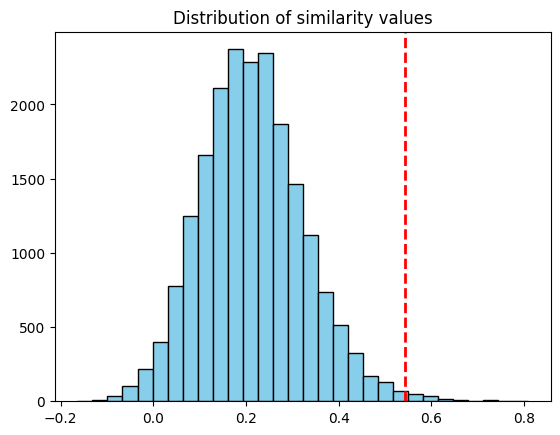

In [151]:
similarity_values = df_melt['values']

# Distribution
plt.hist(similarity_values, bins=30, color='skyblue', edgecolor='black')

plt.axvline(x=threshold_value, color='red', linestyle='--', linewidth=2, label='Threshold')

plt.title('Distribution of similarity values')
plt.show()

In [19]:
# merge target info
df_melt_filtered_merged = df_melt_filtered.merge(ntp_sdgs[['項目', '編號', '指標 ']], left_on='target', right_on='編號', how='inner')

# merge source info
df_melt_filtered_merged = df_melt_filtered_merged.merge(un_sdgs[['ID', 'Goal', 'Indicator']], left_on='source', right_on='ID', how='inner')
df_melt_filtered_merged.drop(['編號','ID'], axis=1, inplace=True)

In [20]:
del model

## Output Format

In [21]:
framework = {
    'data':[],
    'links':[]
}

In [22]:
# UN SDGs Goal Mapping
sdgs_goal = [
    {'code':'SDG1', 'Goal':'1', 'Goal_text':'No Poverty', 'indicator':'End poverty in all its forms everywhere'},
    {'code':'SDG2', 'Goal':'2', 'Goal_text':'Zero Hunger','indicator':'End hunger, achieve food security and improved nutrition and promote sustainable agriculture'},
    {'code':'SDG3', 'Goal':'3', 'Goal_text':'Good Health and Well-Being','indicator':'Ensure healthy lives and promote well-being for all at all ages'},
    {'code':'SDG4', 'Goal':'4', 'Goal_text':'Quality Education','indicator':'Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all'},
    {'code':'SDG5', 'Goal':'5', 'Goal_text':'Gender Equality','indicator':'Achieve gender equality and empower all women and girls'},
    {'code':'SDG6', 'Goal':'6', 'Goal_text':'Clean Water and Sanitation','indicator':'Ensure availability and sustainable management of water and sanitation for all'},
    {'code':'SDG7', 'Goal':'7', 'Goal_text':'Affordable and Clean Energy','indicator':'Ensure access to affordable, reliable, sustainable and modern energy for all'},
    {'code':'SDG8', 'Goal':'8', 'Goal_text':'Decent Work and Economic Growth','indicator':'Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all'},
    {'code':'SDG9', 'Goal':'9', 'Goal_text':'Industry, Innovation and Infrastructure','indicator':'Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation'},
    {'code':'SDG10', 'Goal':'10', 'Goal_text':'Reduced Inequalities','indicator':'Reduce inequality within and among countries'},
    {'code':'SDG11', 'Goal':'11', 'Goal_text':'Sustainable Cities and Communities','indicator':'Make cities and human settlements inclusive, safe, resilient and sustainable'},
    {'code':'SDG12', 'Goal':'12', 'Goal_text':'Responsible Consumption and Production','indicator':'Ensure sustainable consumption and production patterns'},
    {'code':'SDG13', 'Goal':'13', 'Goal_text':'Climate Action','indicator':'Take urgent action to combat climate change and its impacts'},
    {'code':'SDG14', 'Goal':'14', 'Goal_text':'Life Below Water','indicator':'Conserve and sustainably use the oceans, seas and marine resources for sustainable development'},
    {'code':'SDG15', 'Goal':'15', 'Goal_text':'Life on Land','indicator':'Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss'},
    {'code':'SDG16', 'Goal':'16', 'Goal_text':'Peace, Justice and Strong Institutions','indicator':'Promote peaceful and inclusive societies for sustainable development, provide access to justice for all and build effective, accountable and inclusive institutions at all levels'},
    {'code':'SDG17', 'Goal':'17', 'Goal_text':'Partnerships for the Goals','indicator':'Strengthen the means of implementation and revitalize the Global Partnership for Sustainable Development'},
]

sdgs_goal_df = pd.DataFrame(sdgs_goal)

### create node info

In [23]:
df_nodes = (pd.concat([
        df_melt_filtered_merged[['target','指標 ','項目']].rename(columns={'target':'code', '指標 ':'indicator','項目':'Goal'}), 
        df_melt_filtered_merged[['source','Indicator','Goal']].rename(columns={'source':'code', 'Indicator':'indicator'}),
        sdgs_goal_df], axis=0)
            .drop_duplicates())

df_nodes['color'] = df_nodes['Goal'].map(sdgs_color_code)

for source, indicator in df_nodes.iterrows():
    # name: code/ description: indicator/ itemStyle: color
    framework['data'].append({
        'name':indicator['code'], 
        'desciption':indicator['indicator'], 
        'itemStyle':{
            'color':indicator['color'], 
            'borderColor':indicator['color']
        }})

### create link info

In [24]:
for index, row in df_melt_filtered_merged.iterrows():
    framework['links'].append({
        'source': row['source'],
        'target': row['target'],
        'value': row['values'],
        'ntp': row['指標 '],
        'un': row['Indicator']
    })

### Create link info between SDG goal and SDG indicators

In [25]:
goal_df = un_sdgs[['ID','Goal']].copy()
goal_df['Goal'] = "SDG"+un_sdgs['Goal']
for (idx, data) in goal_df.iterrows():
    framework['links'].append({'source':data["Goal"], 'target':data["ID"], 'value':1})

In [26]:
import json
with open('mapping_data_3.json', mode='w') as f:
    json.dump(framework, f, ensure_ascii=False)

## Plotly 

In [87]:
# How many percentage of UN indicators that covered by new taipei indicators
print(f"{((248-len(eliminated_id)) / un_sdgs.shape[0])*100:.2f}% of UN indicators covered by New Taipei indicators")
# 資料
labels = ['Not Covered by NTP ind ', 'Covered by NTP ind']
sizes = [len(eliminated_id), un_sdgs.shape[0] - len(eliminated_id)]

# 創建圓餅圖
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.6)])

# 設置標題
fig.update_layout(
    title='Coverage of UN Indicators by New Taipei Indicators',
    width=600,
    height=300)

# 顯示圖表
fig.show()


29.44% of UN indicators covered by New Taipei indicators


In [105]:
df_melt_filtered_merged['Goal'] = df_melt_filtered_merged['Goal'].astype('int')
test = df_melt_filtered_merged[df_melt_filtered_merged['項目']!='0'].drop_duplicates(subset=['source'])
test = test.groupby('Goal', group_keys=False)['target'].apply(lambda x:(x!='0').sum())
total_counts = df_melt_filtered_merged['Goal'].value_counts().sort_index()

In [ ]:
# mapping by New Taipei VLR
ntp_selected = ntp_sdgs[['項目', '指定Mapping']]
ntp_selected.replace('nan', pd.NA, inplace=True)
# ntp_selected.replace('NaN', pd.NA, inplace=True)
ntp_selected = ntp_selected.dropna()
ntp_selected = ntp_selected.drop_duplicates(subset=['指定Mapping'])
ntp_selected['項目'] = ntp_selected['項目'].astype('int')
ntp_selected_group = ntp_selected.groupby('項目')['指定Mapping'].apply(lambda x:x.count())
sdg17 = pd.DataFrame({'指定Mapping':[0]}, index=[17])
ntp_selected_df = pd.DataFrame(ntp_selected_group.sort_index())
ntp_selected_df = pd.concat([ntp_selected_df, sdg17], axis=0)
ntp_selected_df

In [126]:
import plotly.graph_objects as go

df = (test / total_counts).reset_index()
df['Goal'] = df['Goal'].astype('str')
df['Goal'] = "SDG"+df['Goal']
df = df.rename(columns={0:'value'})
df = df.merge(sdgs_goal_df[['code', 'Goal_text']], left_on='Goal', right_on='code', how='inner').drop(['code'], axis=1)
df = df.fillna(0)

fig = go.Figure()

# Radar chart
fig.add_trace(go.Scatterpolar(
    name = 'New Taipei ind by our mapping system',
    r = df['value'].to_list(),
    theta = df['Goal'].to_list(),
    fill='toself',
    hoverinfo='text', 
    text=[f"{goal} <br>{indicator}<br>Value: {value:.2f}" for goal, indicator, value in zip(df['Goal'], df['Goal_text'], df['value'])] 
))

df_ntp_vlr = (ntp_selected_df.squeeze() / total_counts).reset_index()
df_ntp_vlr = df_ntp_vlr.rename(columns={'index':'Goal', 0:'value'})
df_ntp_vlr['Goal'] = df_ntp_vlr['Goal'].astype('str')
df_ntp_vlr['Goal'] = "SDG"+df_ntp_vlr['Goal']
df_ntp_vlr = df_ntp_vlr.merge(sdgs_goal_df[['code', 'Goal_text']], left_on='Goal', right_on='code', how='inner').drop(['code'], axis=1)

# Radar chart by NTP
fig.add_trace(go.Scatterpolar(
    name = 'New Taipei ind by VLR description',
    r = df_ntp_vlr['value'].to_list(),
    theta = df_ntp_vlr['Goal'].to_list(),
    fill='toself',
    hoverinfo='text', 
    text=[f"{goal} <br>{indicator}<br>Value: {value:.2f}" for goal, indicator, value in zip(df_ntp_vlr['Goal'], df_ntp_vlr['Goal_text'], df_ntp_vlr['value'])]
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      range = [0,0.7],
      visible=True
    ),
    angularaxis_rotation=90,
    angularaxis_direction='clockwise'
  ),
  showlegend=True,
  width=600,
  height=400
)
fig.show()


In [122]:
df_sorted = df.sort_values(by='value', ascending=False)
# Bar Chart

fig = go.Figure()
fig.add_trace(go.Bar(
    x = df_sorted['Goal'],
    y = df_sorted['value'],
    text=[f"Value: {value:.2f}" for value in df_sorted['value']],
    hoverinfo='text'
))

fig.update_layout(
    width=600,
    height=400
)

fig.show()

### Testing for chat model

In [111]:
similar_test_example = df_melt_mapping.loc[:10, ['sdg_sentence', 'ntp_sentence']].values.tolist()
similar_test_example

[['Suicide mortality rateDefinitions: \xa0The Suicide mortality rate as defined as the number of suicide deaths in a year, divided by the population, and multiplied by 100 000.\xa0Concepts:',
  '標準化自殺死亡率: 標準化自殺死亡率＝ [ Σ（年齡別自殺死亡率 × 標準年齡別人口 數）] ÷ 標準總人口數'],
 ['National recycling rate, tons of material recycledDefinitions:National Recycling Rate is defined as the quantity of material recycled in the country plus quantities exported for recycling minus material imported intended for recycling out of total waste generated in the country. Note that recycling includes codigestion/anaerobic digestion and composting/aerobic process, but not controlled combustion (incineration) or land application.National recycling rate can be presented by type of waste, including e-waste, plastic waste, municipal waste, and others.Concepts: Material recycled expressed in tons, reported at the last entity in the recycling chain, preferably when tons of material is bought as secondary resource to be used in produc

In [ ]:
from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import(
    PromptTemplate,
)
from langchain_core.prompts.few_shot import FewShotPromptTemplate

from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(api_key=os.environ.get('API_KEY'), model='gpt-4-turbo', temperature=0)
# llm.invoke("how can langsmith help with testing?")

un_indicators_ex1 = 'Suicide mortality rate,"Definitions:  The Suicide mortality rate as defined as the number of suicide deaths in a year, divided by the population, and multiplied by 100 000. Concepts:"'
ntp_indicators_ex1 = '標準化自殺死亡率,標準化自殺死亡率＝ [ Σ（年齡別自殺死亡率 × 標準年齡別人口 數）] ÷ 標準總人口數,'

un_indicators_ex2 = 'Total official international support (official development assistance plus other official flows) to infrastructure,"Definitions:Gross disbursements of total ODA and other official flows from all donors in support of infrastructure.Concepts:ODA: The DAC defines ODA as “those flows to countries and territories on the DAC List of ODA Recipients and to multilateral institutions which are provided by official agencies, including state and local governments, or by their executive agencies; and each transaction   is administered with the promotion of the economic development and welfare of developing countries as its main objective; andis concessional in character and conveys a grant element of at least 25 per cent (calculated at a rate of discount of 10 per cent). (See http://www.oecd.org/dac/stats/officialdevelopmentassistancedefinitionandcoverage.htm)Other official flows (OOF): Other official flows (excluding officially supported export credits) are defined as transactions by the official sector which do not meet the conditions for eligibility as ODA, either because they are not primarily aimed at development, or because they are not sufficiently concessional.(See http://www.oecd.org/dac/stats/documentupload/DCDDAC(2016)3FINAL.pdf,  Para 24).Support to infrastructure includes all CRS sector codes in the 200 series (see here: http://www.oecd.org/dac/stats/purposecodessectorclassification.htm)"'
ntp_indicators_ex2 = '18 歲以上男性嚼檳榔率,依國健署「成人吸菸行為調查」及「健康危害因子監測調查」調查結果,'

# set more few shot
examples = [
    {
        "question": f"{un_indicators_ex1} {ntp_indicators_ex1}",
        "answer":'Similar'
    },
    {
        "question": f"{un_indicators_ex2} {ntp_indicators_ex2}",
        "answer":'Different'
    }
]

example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)

# print(example_prompt.format(**examples[0]))
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"],
)

# print(prompt.format(input="Who was the father of Mary Ball Washington?"))


output_parser = StrOutputParser()
chain = prompt | llm | output_parser

# test_example = """
# National recycling rate, tons of material recycled","Definitions:National Recycling Rate is defined as the quantity of material recycled in the country plus quantities exported for recycling minus material imported intended for recycling out of total waste generated in the country. Note that recycling includes codigestion/anaerobic digestion and composting/aerobic process, but not controlled combustion (incineration) or land application.National recycling rate can be presented by type of waste, including e-waste, plastic waste, municipal waste, and others.Concepts: Material recycled expressed in tons, reported at the last entity in the recycling chain, preferably when tons of material is bought as secondary resource to be used in production facilities during the course of the reporting year; Secondary mineral materials used in the construction sector are excluded; composting is considered recycling for the purposes of this indicator.Recycling is defined under the UNSD/UNEP Questionnaire on Environment Statistics and further for the purpose of these indicators as “Any reprocessing of waste material […] that diverts it from the waste stream, except reuse as fuel. Both reprocessing as the same type of product, and for different purposes should be included. Recycling within industrial plants i.e., at the place of generation should be excluded.”For the purpose of consistency with the Basel Convention reporting and correspondence with EUROSTAT reporting system, Recovery operations R2 to R12 listed in Basel Convention Annex IV, are to be considered as ‘Recycling’ under the UNSD reporting for hazardous waste. Total waste generated is the total amount of waste (both hazardous and non-hazardous) generated in the country during the year. Municipal Solid Waste (MSW) includes waste originating from households, commerce and trade, small businesses, office buildings and institutions (schools, hospitals, government buildings). It also includes bulky waste (e.g., old furniture, mattresses) and waste from selected municipal services, e.g., waste from park and garden maintenance, waste from street cleaning services (street sweepings, the content of litter containers, market cleansing waste), if managed as waste. Further information on MSW is defined in the SDG indicator methodology for 11.6.1. Electronic waste, or e-waste, refers to all items of electrical and electronic equipment (EEE) and its parts that have been discarded by its owner as waste without the intent of re-use. and
# 資源回收率,資源回收量 ÷（垃圾量 + 資源回收量 + 廚餘量）,
# """
# chain.invoke(test_example)


similar_test_example = df_melt_mapping.loc[:10, ['sdg_sentence', 'ntp_sentence']].values.tolist()
different_test_example = df_melt_mapping.loc[df_melt_mapping.shape[0]-10:, ['sdg_sentence', 'ntp_sentence']].values.tolist()

chain.batch([
    # *similar_test_example,
    *different_test_example
])

In [58]:
chain.output_schema.schema()

{'title': 'StrOutputParserOutput', 'type': 'string'}

In [105]:
from langchain_core.prompts import (
    ChatPromptTemplate,
   FewShotChatMessagePromptTemplate
)

un_indicators_ex1 = 'Suicide mortality rate,"Definitions:  The Suicide mortality rate as defined as the number of suicide deaths in a year, divided by the population, and multiplied by 100 000. Concepts:"'
ntp_indicators_ex1 = '標準化自殺死亡率,標準化自殺死亡率＝ [ Σ（年齡別自殺死亡率 × 標準年齡別人口 數）] ÷ 標準總人口數,'

un_indicators_ex2 = 'Total official international support (official development assistance plus other official flows) to infrastructure,"Definitions:Gross disbursements of total ODA and other official flows from all donors in support of infrastructure.Concepts:ODA: The DAC defines ODA as “those flows to countries and territories on the DAC List of ODA Recipients and to multilateral institutions which are provided by official agencies, including state and local governments, or by their executive agencies; and each transaction   is administered with the promotion of the economic development and welfare of developing countries as its main objective; andis concessional in character and conveys a grant element of at least 25 per cent (calculated at a rate of discount of 10 per cent). (See http://www.oecd.org/dac/stats/officialdevelopmentassistancedefinitionandcoverage.htm)Other official flows (OOF): Other official flows (excluding officially supported export credits) are defined as transactions by the official sector which do not meet the conditions for eligibility as ODA, either because they are not primarily aimed at development, or because they are not sufficiently concessional.(See http://www.oecd.org/dac/stats/documentupload/DCDDAC(2016)3FINAL.pdf,  Para 24).Support to infrastructure includes all CRS sector codes in the 200 series (see here: http://www.oecd.org/dac/stats/purposecodessectorclassification.htm)"'
ntp_indicators_ex2 = '18 歲以上男性嚼檳榔率,依國健署「成人吸菸行為調查」及「健康危害因子監測調查」調查結果,'

un_indicators_ex3 = ''
ntp_indicators_ex3 = ''

un_indicators_ex4 = ''
ntp_indicators_ex4 = ''

## Chat Model
examples = [
    {"input":f"{un_indicators_ex1} & {ntp_indicators_ex1}", "output":"Similar"},
    {"input":f"{un_indicators_ex2} & {ntp_indicators_ex2}", "output":"Different"},
    {"input":f"{un_indicators_ex1} & {ntp_indicators_ex1}", "output":"Similar"},
    {"input":f"{un_indicators_ex2} & {ntp_indicators_ex2}", "output":"Different"}
]

example_prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}"),
    ("ai", "{output}"),
])

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
# print(few_shot_prompt.format())

final_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", "You are the head of the Sustainable Development Goals(SDGs) project at the United Nations, \
        #  you will answer questions regarding the comparison of indicators between the UN and local Governments."),
        # ("system", "you will compare the SDGs indicators between United Nations and Local Governments"),
        ("system", "Only answer me 'Similar' or 'Different' "),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)
output_parser = StrOutputParser()
chain = final_prompt | llm | output_parser

test_example = """
National recycling rate, tons of material recycled","Definitions:National Recycling Rate is defined as the quantity of material recycled in the country plus quantities exported for recycling minus material imported intended for recycling out of total waste generated in the country. Note that recycling includes codigestion/anaerobic digestion and composting/aerobic process, but not controlled combustion (incineration) or land application.National recycling rate can be presented by type of waste, including e-waste, plastic waste, municipal waste, and others.Concepts: Material recycled expressed in tons, reported at the last entity in the recycling chain, preferably when tons of material is bought as secondary resource to be used in production facilities during the course of the reporting year; Secondary mineral materials used in the construction sector are excluded; composting is considered recycling for the purposes of this indicator.Recycling is defined under the UNSD/UNEP Questionnaire on Environment Statistics and further for the purpose of these indicators as “Any reprocessing of waste material […] that diverts it from the waste stream, except reuse as fuel. Both reprocessing as the same type of product, and for different purposes should be included. Recycling within industrial plants i.e., at the place of generation should be excluded.”For the purpose of consistency with the Basel Convention reporting and correspondence with EUROSTAT reporting system, Recovery operations R2 to R12 listed in Basel Convention Annex IV, are to be considered as ‘Recycling’ under the UNSD reporting for hazardous waste. Total waste generated is the total amount of waste (both hazardous and non-hazardous) generated in the country during the year. Municipal Solid Waste (MSW) includes waste originating from households, commerce and trade, small businesses, office buildings and institutions (schools, hospitals, government buildings). It also includes bulky waste (e.g., old furniture, mattresses) and waste from selected municipal services, e.g., waste from park and garden maintenance, waste from street cleaning services (street sweepings, the content of litter containers, market cleansing waste), if managed as waste. Further information on MSW is defined in the SDG indicator methodology for 11.6.1. Electronic waste, or e-waste, refers to all items of electrical and electronic equipment (EEE) and its parts that have been discarded by its owner as waste without the intent of re-use. and
資源回收率,資源回收量 ÷（垃圾量 + 資源回收量 + 廚餘量）,
"""

# chain.invoke(f"{test_example}")

chain.batch([
    *similar_test_example,
    *different_test_example
])



['Different',
 'Different',
 'Similar',
 'Different',
 'Similar',
 'Similar',
 'Similar',
 'Similar',
 'Different',
 'Different',
 'Similar',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different',
 'Different']

In [55]:
# from langchain_community.document_loaders.csv_loader import CSVLoader
# loader = CSVLoader(file_path=r"un_sdgs_indicators.csv", source_column="Indicator")
# data = loader.load()

In [ ]:
from langchain_community.document_loaders import DataFrameLoader
loader = DataFrameLoader(un_sdgs, page_content_column="Indicator")
# loader.load()
for i in loader.lazy_load():
    print(i)
